In [6]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv

# Déf de l'env 6

In [7]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from collections import deque

class KubernetesSchedulerEnvRealistic(gym.Env):
    """
    Environnement réaliste pour l'ordonnancement de pods Kubernetes
    Avec file d'attente et réessai des pods skipés
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, num_nodes=10, num_pods=50, pod_list=None,
                 cpu_req_range=(1.0, 4.0), mem_req_range=(2.0, 16.0), 
                 seed=None, max_wait_time=3):
        super().__init__()

        self.num_nodes = num_nodes
        self.num_pods = num_pods
        self.max_cpu_per_node = 8.0
        self.max_memory_per_node = 32.0
        self.max_wait_time = max_wait_time  # Nombre max de réessais

        self.pod_list = pod_list
        self.cpu_req_range = cpu_req_range
        self.mem_req_range = mem_req_range
        self.seed_value = seed
        if seed is not None:
            np.random.seed(seed)

        # Observation : 4 features par node + 2 pod + 6 stats globaux
        obs_size = num_nodes * 4 + 2 + 6
        self.observation_space = spaces.Box(low=0, high=1, shape=(obs_size,), dtype=np.float32)
        self.action_space = spaces.Discrete(num_nodes + 1)  # +1 = skip

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)
            self.seed_value = seed

        # Initialisation nodes
        self.nodes = np.zeros((self.num_nodes, 4), dtype=np.float32)
        for i in range(self.num_nodes):
            self.nodes[i] = [0, 0, self.max_cpu_per_node, self.max_memory_per_node]

        # Pods initiaux avec compteur d'attente
        if self.pod_list is not None:
            self.pending_pods = []
            for pod in self.pod_list:
                self.pending_pods.append({
                    'cpu_req': pod[0],
                    'mem_req': pod[1],
                    'wait_count': 0
                })
        else:
            self.pending_pods = []
            for _ in range(self.num_pods):
                cpu_req = np.random.uniform(*self.cpu_req_range)
                mem_req = np.random.uniform(*self.mem_req_range)
                self.pending_pods.append({
                    'cpu_req': cpu_req,
                    'mem_req': mem_req,
                    'wait_count': 0
                })

        # File d'attente FIFO
        self.waiting_queue = deque(self.pending_pods.copy())
        
        # Stats
        self.total_reward = 0
        self.successful_placements = 0
        self.steps_taken = 0
        self.skipped_pods = 0
        self.failed_placements = 0
        self.current_pod = None
        
        # Prendre le premier pod de la file
        self._get_next_pod()

        return self._get_observation().astype(np.float32), {}

    def _get_next_pod(self):
        """Prend le prochain pod de la file d'attente"""
        if len(self.waiting_queue) > 0:
            self.current_pod = self.waiting_queue.popleft()
        else:
            self.current_pod = None

    def _get_observation(self):
        nodes_state = []
        total_cpu_used = 0
        total_mem_used = 0
        
        for n in self.nodes:
            cpu_used, mem_used, cpu_total, mem_total = n
            cpu_free = cpu_total - cpu_used
            mem_free = mem_total - mem_used
            nodes_state.extend([
                cpu_used / cpu_total,
                mem_used / mem_total,
                cpu_free / self.max_cpu_per_node,
                mem_free / self.max_memory_per_node
            ])
            total_cpu_used += cpu_used
            total_mem_used += mem_used

        # Pod courant
        pod_state = [0, 0]
        if self.current_pod is not None:
            pod_state = [
                self.current_pod['cpu_req'] / self.max_cpu_per_node,
                self.current_pod['mem_req'] / self.max_memory_per_node
            ]

        # Stats globales
        avg_cpu_util = total_cpu_used / (self.num_nodes * self.max_cpu_per_node)
        avg_mem_util = total_mem_used / (self.num_nodes * self.max_memory_per_node)
        queue_size = len(self.waiting_queue)
        
        global_stats = [
            self.successful_placements / max(len(self.pending_pods), 1),
            queue_size / max(len(self.pending_pods), 1),
            avg_cpu_util,
            avg_mem_util,
            self.current_pod['wait_count'] / self.max_wait_time if self.current_pod else 0,
            (self.skipped_pods + self.failed_placements) / max(len(self.pending_pods), 1)
        ]

        return np.array(nodes_state + pod_state + global_stats, dtype=np.float32)

    def step(self, action):
        terminated = False
        truncated = False
        reward = 0
        info = {"placement": "none", "wait_count": 0}

        # Vérifier si plus de pods
        if self.current_pod is None:
            terminated = True
            return self._get_observation().astype(np.float32), reward, terminated, truncated, info

        cpu_req = self.current_pod['cpu_req']
        mem_req = self.current_pod['mem_req']
        wait_count = self.current_pod['wait_count']

        # Placement sur un nœud
        if action < self.num_nodes:
            node = self.nodes[action]
            cpu_used, mem_used, cpu_total, mem_total = node

            if cpu_used + cpu_req <= cpu_total and mem_used + mem_req <= mem_total:
                # Placement réussi
                self.nodes[action][0] += cpu_req
                self.nodes[action][1] += mem_req
                self.successful_placements += 1

                cpu_ratio = (cpu_used + cpu_req) / cpu_total
                mem_ratio = (mem_used + mem_req) / mem_total
                
                # Bonus pour faible temps d'attente
                wait_bonus = max(0, 0.3 * (1 - wait_count / self.max_wait_time))
                reward = 1.0 + 0.5 * (1 - abs(cpu_ratio - mem_ratio)) + wait_bonus
                info["placement"] = "success"
                info["wait_count"] = wait_count
                
                # Pod placé, on le supprime
                self._get_next_pod()
                
            else:
                # Échec de placement (ressources insuffisantes)
                self.failed_placements += 1
                reward = -1.0
                info["placement"] = "failed"
                
                # Incrémenter compteur d'attente
                self.current_pod['wait_count'] += 1
                
                # Vérifier si on abandonne le pod
                if self.current_pod['wait_count'] >= self.max_wait_time:
                    # Abandon après trop d'attentes
                    info["placement"] = "abandoned"
                    self._get_next_pod()
                else:
                    # Remettre en fin de file
                    self.waiting_queue.append(self.current_pod.copy())
                    self._get_next_pod()
        
        # Action "skip"
        else:
            self.skipped_pods += 1
            info["placement"] = "skipped"
            info["wait_count"] = wait_count
            
            # Incrémenter compteur d'attente
            self.current_pod['wait_count'] += 1
            
            # Vérifier si on abandonne le pod
            if self.current_pod['wait_count'] >= self.max_wait_time:
                # Abandon après trop de skips
                reward = -0.8
                info["placement"] = "abandoned"
                self._get_next_pod()
            else:
                # Remettre en fin de file avec pénalité variable
                reward = -0.1 * (self.current_pod['wait_count'] + 1)
                self.waiting_queue.append(self.current_pod.copy())
                self._get_next_pod()

        self.steps_taken += 1
        self.total_reward += reward

        # Fin d'épisode : plus de pods dans la file et pas de pod courant
        if self.current_pod is None and len(self.waiting_queue) == 0:
            terminated = True
            success_rate = self.successful_placements / max(len(self.pending_pods), 1)
            reward += 2.0 * success_rate
            info["final_success_rate"] = success_rate
            info["total_reward"] = self.total_reward
            info["placement_rate"] = success_rate
            info["avg_wait_time"] = sum(p['wait_count'] for p in self.pending_pods) / max(len(self.pending_pods), 1)

        return self._get_observation().astype(np.float32), reward, terminated, truncated, info

    def render(self, mode="human"):
        print(f"\n=== Épisode (Version Réaliste) ===")
        print(f"Étapes: {self.steps_taken}")
        print(f"Pods placés: {self.successful_placements}/{len(self.pending_pods)}")
        print(f"Pods en attente: {len(self.waiting_queue)}")
        print(f"Pods skipés: {self.skipped_pods}")
        print(f"Pods abandonnés: {self.failed_placements}")
        print(f"Récompense totale: {self.total_reward:.2f}")
        
        if self.current_pod is None and len(self.waiting_queue) == 0:
            success_rate = self.successful_placements / max(len(self.pending_pods), 1)
            print(f"Taux de placement final: {success_rate:.1%}")
        
        # Afficher le pod courant si disponible
        if self.current_pod is not None:
            print(f"Pod courant: CPU={self.current_pod['cpu_req']:.1f}, "
                  f"MEM={self.current_pod['mem_req']:.1f}, "
                  f"Attente={self.current_pod['wait_count']}")

        # Afficher les nœuds chargés
        for i, node in enumerate(self.nodes):
            cpu_used, mem_used, cpu_total, mem_total = node
            if cpu_used/cpu_total > 0.4 or mem_used/mem_total > 0.4:
                print(f"Node {i}: CPU {cpu_used:.1f}/{cpu_total:.1f} "
                      f"({cpu_used/cpu_total:.1%}), "
                      f"MEM {mem_used:.1f}/{mem_total:.1f} ({mem_used/mem_total:.1%})")

    def get_metrics(self):
        total_cpu_used = sum([n[0] for n in self.nodes])
        total_mem_used = sum([n[1] for n in self.nodes])
        total_wait_time = sum(p['wait_count'] for p in self.pending_pods)
        
        return {
            "total_reward": self.total_reward,
            "successful_placements": self.successful_placements,
            "total_pods": len(self.pending_pods),
            "placement_rate": self.successful_placements / max(len(self.pending_pods), 1),
            "steps_taken": self.steps_taken,
            "queue_size": len(self.waiting_queue),
            "avg_cpu_util": total_cpu_used / (self.num_nodes * self.max_cpu_per_node),
            "avg_mem_util": total_mem_used / (self.num_nodes * self.max_memory_per_node),
            "avg_wait_time": total_wait_time / max(len(self.pending_pods), 1),
            "skipped_pods": self.skipped_pods,
            "failed_placements": self.failed_placements,
            "nodes_used_percentage": np.sum([1 for n in self.nodes if n[0] > 0]) / self.num_nodes
        }

    def close(self):
        pass

# Agent PPO

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

class PPOAgentComplex:
    def __init__(self, env, model_name="ppo_k8s_complex", save_path="results/models_complex/"):
        # Vérifier que c'est un environnement réaliste
        if not (hasattr(env, 'waiting_queue') or hasattr(env, 'current_pod')):
            print("⚠️ Attention : Cet agent est conçu pour l'environnement complexe")
        
        self.env = DummyVecEnv([lambda: Monitor(env)])
        self.raw_env = env  # Garder une référence à l'environnement original
        self.model_name = model_name
        self.model = None
        self.best_model_path = None
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)
        check_env(env, warn=True)

    def train(self, total_timesteps=50000, save_file_name=None, 
              eval_freq=1000, n_eval_episodes=5):
        
        # Créer l'environnement d'évaluation
        eval_env = Monitor(self.raw_env)
        
        # Callback d'évaluation
        eval_callback = EvalCallback(
            eval_env,
            best_model_save_path=self.save_path,
            log_path=self.save_path,
            eval_freq=eval_freq,
            n_eval_episodes=n_eval_episodes,
            deterministic=True,
            render=False
        )
        
        # Callback de sauvegarde
        checkpoint_callback = CheckpointCallback(
            save_freq=5000,
            save_path=self.save_path,
            name_prefix=f"{self.model_name}_checkpoint"
        )
        
        # Créer le modèle
        self.model = PPO(
            "MlpPolicy",
            self.env,
            verbose=1,
            learning_rate=2.5e-4,
            n_steps=2048,
            batch_size=64,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
            ent_coef=0.01,
            vf_coef=0.5,
            max_grad_norm=0.5,
            tensorboard_log="./ppo_k8s_complex_tensorboard/"
        )
        
        # Entraînement avec callbacks
        print(f"🚀 Début de l'entraînement PPO sur environnement complexe ({total_timesteps} steps)...")
        self.model.learn(
            total_timesteps=total_timesteps,
            callback=[eval_callback, checkpoint_callback],
            progress_bar=True
        )
        
        # Sauvegarde finale
        if save_file_name is None:
            save_file_name = f"{self.model_name}_final.zip"
        
        final_model_path = os.path.join(self.save_path, save_file_name)
        self.model.save(final_model_path)
        self.best_model_path = final_model_path
        print(f"✅ Modèle sauvegardé : {final_model_path}")
        
        return self

    def load(self, model_path=None, best_model=False):
        if best_model:
            model_path = self.best_model_path
        if model_path is None:
            raise ValueError("Aucun modèle spécifié pour le chargement.")
        self.model = PPO.load(model_path, env=self.env)
        print(f"📂 Modèle chargé : {model_path}")
        return self

    def predict(self, observation, deterministic=True):
        if observation.ndim == 1:
            observation = observation[None, :]
        action, _ = self.model.predict(observation, deterministic=deterministic)
        return action[0]

    def evaluate_comprehensive(self, num_episodes=20, render_every=5):
        """
        Évaluation complète de l'agent sur l'environnement complexe
        """
        metrics = {
            'placement_rates': [],
            'total_rewards': [],
            'avg_wait_times': [],
            'successful_placements': [],
            'skipped_pods': [],
            'failed_placements': [],
            'avg_cpu_util': [],
            'avg_mem_util': []
        }
        
        print(f"\n{'='*60}")
        print(f"ÉVALUATION DE L'AGENT PPO SUR ENVIRONNEMENT COMPLEXE")
        print(f"{'='*60}")
        
        for episode in range(num_episodes):
            obs, _ = self.raw_env.reset()
            done = False
            episode_reward = 0
            steps = 0
            
            while not done:
                # Prédiction de l'agent
                action = self.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.raw_env.step(action)
                
                episode_reward += reward
                steps += 1
                done = terminated or truncated
                
                # Limite de sécurité
                if steps > 1000:
                    print(f"  ⚠️ Épisode {episode+1}: Trop d'étapes ({steps}), arrêt")
                    break
            
            # Récupérer les métriques finales
            final_metrics = self.raw_env.get_metrics()
            
            # Stocker les résultats
            metrics['placement_rates'].append(final_metrics['placement_rate'])
            metrics['total_rewards'].append(episode_reward)
            metrics['avg_wait_times'].append(final_metrics.get('avg_wait_time', 0))
            metrics['successful_placements'].append(final_metrics['successful_placements'])
            metrics['skipped_pods'].append(final_metrics.get('skipped_pods', 0))
            metrics['failed_placements'].append(final_metrics.get('failed_placements', 0))
            metrics['avg_cpu_util'].append(final_metrics.get('avg_cpu_util', 0))
            metrics['avg_mem_util'].append(final_metrics.get('avg_mem_util', 0))
            
            # Afficher périodiquement
            if (episode + 1) % render_every == 0:
                print(f"  📊 Épisode {episode + 1}/{num_episodes}: "
                      f"Placement={final_metrics['placement_rate']:.1%}, "
                      f"Reward={episode_reward:.2f}, "
                      f"Wait={final_metrics.get('avg_wait_time', 0):.2f}")
        
        # Calculer et afficher les statistiques globales
        self._print_evaluation_summary(metrics)
        
        return metrics
    
    def _print_evaluation_summary(self, metrics):
        """Affiche un résumé des résultats d'évaluation"""
        print(f"\n{'='*60}")
        print("RÉSULTATS GLOBAUX")
        print(f"{'='*60}")
        
        print(f"\n🎯 PERFORMANCE DE PLACEMENT:")
        print(f"  • Taux moyen: {np.mean(metrics['placement_rates']):.1%}")
        print(f"  • Écart-type: {np.std(metrics['placement_rates']):.1%}")
        print(f"  • Min: {np.min(metrics['placement_rates']):.1%}")
        print(f"  • Max: {np.max(metrics['placement_rates']):.1%}")
        
        print(f"\n💰 RÉCOMPENSES:")
        print(f"  • Moyenne: {np.mean(metrics['total_rewards']):.2f}")
        print(f"  • Écart-type: {np.std(metrics['total_rewards']):.2f}")
        
        print(f"\n⏱️ TEMPS D'ATTENTE:")
        print(f"  • Moyen: {np.mean(metrics['avg_wait_times']):.2f} étapes")
        
        print(f"\n📊 RÉPARTITION DES PODS:")
        print(f"  • Réussis: {np.mean(metrics['successful_placements']):.1f} pods/épisode")
        print(f"  • Skipés: {np.mean(metrics['skipped_pods']):.1f} pods/épisode")
        print(f"  • Échecs: {np.mean(metrics['failed_placements']):.1f} pods/épisode")
        
        print(f"\n💻 UTILISATION DES RESSOURCES:")
        print(f"  • CPU moyen: {np.mean(metrics['avg_cpu_util']):.1%}")
        print(f"  • Mémoire moyenne: {np.mean(metrics['avg_mem_util']):.1%}")
    
    def plot_evaluation_results(self, metrics, save_path=None):
        """Visualise les résultats de l'évaluation"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Évaluation PPO - Environnement Complexe Kubernetes', fontsize=16)
        
        # 1. Taux de placement
        axes[0, 0].plot(metrics['placement_rates'], marker='o', alpha=0.7, linewidth=2)
        axes[0, 0].axhline(y=np.mean(metrics['placement_rates']), color='red', 
                          linestyle='--', linewidth=1.5, 
                          label=f'Moyenne: {np.mean(metrics["placement_rates"]):.1%}')
        axes[0, 0].set_title('Taux de placement par épisode', fontsize=12)
        axes[0, 0].set_xlabel('Épisode')
        axes[0, 0].set_ylabel('Taux de placement')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Récompenses
        axes[0, 1].plot(metrics['total_rewards'], marker='s', alpha=0.7, 
                       color='green', linewidth=2)
        axes[0, 1].axhline(y=np.mean(metrics['total_rewards']), color='red', 
                          linestyle='--', linewidth=1.5,
                          label=f'Moyenne: {np.mean(metrics["total_rewards"]):.2f}')
        axes[0, 1].set_title('Récompenses totales', fontsize=12)
        axes[0, 1].set_xlabel('Épisode')
        axes[0, 1].set_ylabel('Récompense')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Temps d'attente
        axes[0, 2].plot(metrics['avg_wait_times'], marker='^', alpha=0.7, 
                       color='orange', linewidth=2)
        axes[0, 2].axhline(y=np.mean(metrics['avg_wait_times']), color='red', 
                          linestyle='--', linewidth=1.5,
                          label=f'Moyenne: {np.mean(metrics["avg_wait_times"]):.2f}')
        axes[0, 2].set_title('Temps d\'attente moyen', fontsize=12)
        axes[0, 2].set_xlabel('Épisode')
        axes[0, 2].set_ylabel('Attente (étapes)')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Histogramme des taux
        axes[1, 0].hist(metrics['placement_rates'], bins=15, 
                       edgecolor='black', alpha=0.7, color='skyblue')
        axes[1, 0].axvline(x=np.mean(metrics['placement_rates']), color='red', 
                          linestyle='--', linewidth=2,
                          label=f'Moyenne: {np.mean(metrics["placement_rates"]):.1%}')
        axes[1, 0].set_title('Distribution des taux de placement', fontsize=12)
        axes[1, 0].set_xlabel('Taux de placement')
        axes[1, 0].set_ylabel('Fréquence')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Répartition des décisions
        categories = ['Réussis', 'Skip', 'Échecs']
        values = [
            np.mean(metrics['successful_placements']),
            np.mean(metrics['skipped_pods']),
            np.mean(metrics['failed_placements'])
        ]
        colors = ['green', 'orange', 'red']
        bars = axes[1, 1].bar(categories, values, color=colors, edgecolor='black')
        axes[1, 1].set_title('Répartition moyenne des décisions', fontsize=12)
        axes[1, 1].set_ylabel('Nombre moyen de pods')
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                           f'{val:.1f}', ha='center', va='bottom')
        
        # 6. Utilisation des ressources
        x = range(len(metrics['avg_cpu_util']))
        axes[1, 2].plot(x, metrics['avg_cpu_util'], marker='o', label='CPU', 
                       linewidth=2, alpha=0.7)
        axes[1, 2].plot(x, metrics['avg_mem_util'], marker='s', label='Mémoire', 
                       linewidth=2, alpha=0.7)
        axes[1, 2].axhline(y=0.7, color='red', linestyle='--', alpha=0.5, 
                          label='Seuil 70%')
        axes[1, 2].set_title('Utilisation des ressources', fontsize=12)
        axes[1, 2].set_xlabel('Épisode')
        axes[1, 2].set_ylabel('Utilisation')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📈 Graphiques sauvegardés : {save_path}")
        
        plt.show()

# Train

In [9]:
# Créer l'environnement complexe
env_complex = KubernetesSchedulerEnvRealistic(
    num_nodes=10,
    num_pods=50,
    seed=42,
    max_wait_time=3
)

# Créer l'agent PPO pour l'environnement complexe
ppo_agent_complex = PPOAgentComplex(
    env=env_complex,
    model_name="ppo_k8s_scheduler_complex",
    save_path="results/models_complex/"
)

# Option 1 : Entraîner un nouveau modèle
print("🚀 Démarrage de l'entraînement...")
ppo_agent_complex.train(
    total_timesteps=50000,  # À ajuster selon vos ressources
    save_file_name="ppo_complex_model_final.zip",
    eval_freq=2500,
    n_eval_episodes=5
)

# Option 2 : Charger un modèle pré-entraîné
# ppo_agent_complex.load(model_path="results/models_complex/ppo_k8s_scheduler_complex_final.zip")



⚠️ Attention : Cet agent est conçu pour l'environnement complexe
🚀 Démarrage de l'entraînement...
Using cpu device
🚀 Début de l'entraînement PPO sur environnement complexe (50000 steps)...
Logging to ./ppo_k8s_complex_tensorboard/PPO_1


C:\Users\malek\anaconda3\envs\rl_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.4     |
|    ep_rew_mean     | -11.8    |
| time/              |          |
|    fps             | 624      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


Eval num_timesteps=2500, episode_reward=-129.02 +/- 2.33

Episode length: 141.20 +/- 0.98

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 141         |
|    mean_reward          | -129        |
| time/                   |             |
|    total_timesteps      | 2500        |
| train/                  |             |
|    approx_kl            | 0.013425177 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.007       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.29        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00997    |
|    value_loss           | 25.6        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.7     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    fps             | 381      |
|    iterations      | 2        |
|    time_elapsed    | 10       |
|    total_timesteps | 4096     |
---------------------------------


Eval num_timesteps=5000, episode_reward=-132.02 +/- 2.04

Episode length: 142.40 +/- 0.80

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 142         |
|    mean_reward          | -132        |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.010545755 |
|    clip_fraction        | 0.0615      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.703       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.3        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0088     |
|    value_loss           | 26.6        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.7     |
|    ep_rew_mean     | -11.7    |
| time/              |          |
|    fps             | 339      |
|    iterations      | 3        |
|    t

Eval num_timesteps=7500, episode_reward=-60.83 +/- 4.87

Episode length: 144.40 +/- 1.02

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 144         |
|    mean_reward          | -60.8       |
| time/                   |             |
|    total_timesteps      | 7500        |
| train/                  |             |
|    approx_kl            | 0.009018432 |
|    clip_fraction        | 0.0789      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.81        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 23.1        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.7     |
|    ep_rew_mean     | -11.9    |
| time/              |          |
|    fps             | 327      |
|    iterations      | 4        |
|    time_elapsed    | 25       |
|    total_timesteps | 8192     |
---------------------------------


Eval num_timesteps=10000, episode_reward=-58.24 +/- 2.28

Episode length: 145.60 +/- 1.50

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 146        |
|    mean_reward          | -58.2      |
| time/                   |            |
|    total_timesteps      | 10000      |
| train/                  |            |
|    approx_kl            | 0.00985072 |
|    clip_fraction        | 0.0218     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.38      |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.29       |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.00716   |
|    value_loss           | 14.9       |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.1     |
|    ep_rew_mean     | -11.8    |
| time/              |          |
|    fps             | 324      |
|    iterations      | 5        |
|    time_elapsed    | 31       |
|    total_timesteps | 10240    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.2        |
|    ep_rew_mean          | -11.4       |
| time/                   |             |
|    fps                  | 327         |
|    iterations           | 6           |
|    time_elapsed         | 37          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.011558931 |
|    clip_fraction        | 0.066       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.37       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.

Eval num_timesteps=12500, episode_reward=-55.46 +/- 0.56

Episode length: 143.60 +/- 0.80

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 144         |
|    mean_reward          | -55.5       |
| time/                   |             |
|    total_timesteps      | 12500       |
| train/                  |             |
|    approx_kl            | 0.012543911 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.35       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.11        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 3.5         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.5     |
|    ep_rew_mean     | -11      |
| time/              |          |
|    fps             | 321      |
|    iterations      | 7        |
|    time_elapsed    | 44       |
|    total_timesteps | 14336    |
---------------------------------


Eval num_timesteps=15000, episode_reward=-56.69 +/- 1.10

Episode length: 144.40 +/- 0.80

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 144         |
|    mean_reward          | -56.7       |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.009768304 |
|    clip_fraction        | 0.0731      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.33       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.66        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 6.54        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    fps             | 322      |
|    iterations      | 8        |
|    t

Eval num_timesteps=17500, episode_reward=-50.55 +/- 2.61

Episode length: 142.60 +/- 0.80

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 143         |
|    mean_reward          | -50.5       |
| time/                   |             |
|    total_timesteps      | 17500       |
| train/                  |             |
|    approx_kl            | 0.007352909 |
|    clip_fraction        | 0.0522      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.31       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.84        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 4.69        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.9     |
|    ep_rew_mean     | -8.76    |
| time/              |          |
|    fps             | 309      |
|    iterations      | 9        |
|    time_elapsed    | 59       |
|    total_timesteps | 18432    |
---------------------------------


Eval num_timesteps=20000, episode_reward=-52.31 +/- 2.32

Episode length: 141.80 +/- 1.33

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 142         |
|    mean_reward          | -52.3       |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.012245781 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.27       |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.00025     |
|    loss                 | 1.61        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 5.55        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.8     |
|    ep_rew_mean     | -7.17    |
| time/              |          |
|    fps             | 307      |
|    iterations      | 10       |
|    t

Eval num_timesteps=22500, episode_reward=-51.78 +/- 1.17

Episode length: 142.20 +/- 1.33

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 142         |
|    mean_reward          | -51.8       |
| time/                   |             |
|    total_timesteps      | 22500       |
| train/                  |             |
|    approx_kl            | 0.009400327 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.00025     |
|    loss                 | 1.61        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 5.28        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -6.32    |
| time/              |          |
|    fps             | 304      |
|    iterations      | 11       |
|    t

Eval num_timesteps=25000, episode_reward=-45.67 +/- 4.12

Episode length: 139.20 +/- 2.14

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 139         |
|    mean_reward          | -45.7       |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.010755241 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.964       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 2.27        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -3.08    |
| time/              |          |
|    fps             | 303      |
|    iterations      | 13       |
|    time_elapsed    | 87       |
|    total_timesteps | 26624    |
---------------------------------


Eval num_timesteps=27500, episode_reward=-48.84 +/- 0.82

Episode length: 143.20 +/- 1.47

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 143         |
|    mean_reward          | -48.8       |
| time/                   |             |
|    total_timesteps      | 27500       |
| train/                  |             |
|    approx_kl            | 0.009757383 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.99       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.809       |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 3.48        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -0.865   |
| time/              |          |
|    fps             | 304      |
|    iterations      | 14       |
|    t

Eval num_timesteps=30000, episode_reward=-42.12 +/- 3.10

Episode length: 140.80 +/- 1.33

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 141         |
|    mean_reward          | -42.1       |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.008378036 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.88       |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.22        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 5.25        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 0.103    |
| time/              |          |
|    fps             | 307      |
|    iterations      | 15       |
|    time_elapsed    | 99       |
|    total_timesteps | 30720    |
---------------------------------


Eval num_timesteps=32500, episode_reward=-36.05 +/- 1.31

Episode length: 137.80 +/- 0.75

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 138         |
|    mean_reward          | -36         |
| time/                   |             |
|    total_timesteps      | 32500       |
| train/                  |             |
|    approx_kl            | 0.009394889 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.82       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.819       |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 2.25        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.09     |
| time/              |          |
|    fps             | 305      |
|    iterations      | 16       |
|    time_elapsed    | 107      |
|    total_timesteps | 32768    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 103         |
|    ep_rew_mean          | 2.76        |
| time/                   |             |
|    fps                  | 305         |
|    iterations           | 17          |
|    time_elapsed         | 113         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.011702532 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.

Eval num_timesteps=35000, episode_reward=-17.88 +/- 4.06

Episode length: 130.20 +/- 1.72

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 130         |
|    mean_reward          | -17.9       |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.008370498 |
|    clip_fraction        | 0.0595      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.497       |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 1.9         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 4.11     |
| time/              |          |
|    fps             | 303      |
|    iterations      | 18       |
|    time_elapsed    | 121      |
|    total_timesteps | 36864    |
---------------------------------


Eval num_timesteps=37500, episode_reward=-11.42 +/- 6.65

Episode length: 129.60 +/- 3.38

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 130         |
|    mean_reward          | -11.4       |
| time/                   |             |
|    total_timesteps      | 37500       |
| train/                  |             |
|    approx_kl            | 0.010022967 |
|    clip_fraction        | 0.0945      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.8        |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.00025     |
|    loss                 | 0.741       |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 4.63        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 4.74     |
| time/              |          |
|    fps             | 300      |
|    iterations      | 19       |
|    time_elapsed    | 129      |
|    total_timesteps | 38912    |
---------------------------------


Eval num_timesteps=40000, episode_reward=-4.26 +/- 4.59

Episode length: 125.80 +/- 1.72

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 126         |
|    mean_reward          | -4.26       |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.008718723 |
|    clip_fraction        | 0.0833      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.76        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 4.67        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 5.2      |
| time/              |          |
|    fps             | 299      |
|    iterations      | 20       |
|    time_elapsed    | 136      |
|    total_timesteps | 40960    |
---------------------------------


Eval num_timesteps=42500, episode_reward=-6.56 +/- 1.93

Episode length: 124.80 +/- 1.17

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 125         |
|    mean_reward          | -6.56       |
| time/                   |             |
|    total_timesteps      | 42500       |
| train/                  |             |
|    approx_kl            | 0.009528042 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.94        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 4.66        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 105      |
|    ep_rew_mean     | 5.58     |
| time/              |          |
|    fps             | 299      |
|    iterations      | 21       |
|    t

Eval num_timesteps=45000, episode_reward=-2.73 +/- 3.57

Episode length: 124.80 +/- 1.83

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 125         |
|    mean_reward          | -2.73       |
| time/                   |             |
|    total_timesteps      | 45000       |
| train/                  |             |
|    approx_kl            | 0.008743128 |
|    clip_fraction        | 0.0959      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.46        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 3.99        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 6.13     |
| time/              |          |
|    fps             | 300      |
|    iterations      | 22       |
|    time_elapsed    | 149      |
|    total_timesteps | 45056    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | 6.38        |
| time/                   |             |
|    fps                  | 302         |
|    iterations           | 23          |
|    time_elapsed         | 155         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.009337394 |
|    clip_fraction        | 0.0824      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.

Eval num_timesteps=47500, episode_reward=1.48 +/- 3.65

Episode length: 118.60 +/- 2.06

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 119         |
|    mean_reward          | 1.48        |
| time/                   |             |
|    total_timesteps      | 47500       |
| train/                  |             |
|    approx_kl            | 0.008676438 |
|    clip_fraction        | 0.0985      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.708       |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 1.73        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 7.37     |
| time/              |          |
|    fps             | 301      |
|    iterations      | 24       |
|    time_elapsed    | 163      |
|    total_timesteps | 49152    |
---------------------------------


Eval num_timesteps=50000, episode_reward=3.88 +/- 4.53

Episode length: 116.40 +/- 1.36

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 116          |
|    mean_reward          | 3.88         |
| time/                   |              |
|    total_timesteps      | 50000        |
| train/                  |              |
|    approx_kl            | 0.0061494685 |
|    clip_fraction        | 0.0684       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.62        |
|    explained_variance   | 0.917        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.982        |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00921     |
|    value_loss           | 5.25         |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | 8.05     |
| time/              |          |
|    fps             | 300      |
|    iterations      | 25       |
|    time_elapsed    | 170      |
|    total_timesteps | 51200    |
---------------------------------


✅ Modèle sauvegardé : results/models_complex/ppo_complex_model_final.zip


# test 


📊 Démarrage de l'évaluation...

ÉVALUATION DE L'AGENT PPO SUR ENVIRONNEMENT COMPLEXE
  📊 Épisode 5/30: Placement=46.0%, Reward=0.31, Wait=0.74
  📊 Épisode 10/30: Placement=42.0%, Reward=-6.89, Wait=0.70
  📊 Épisode 15/30: Placement=50.0%, Reward=5.71, Wait=0.72
  📊 Épisode 20/30: Placement=42.0%, Reward=-5.74, Wait=0.72
  📊 Épisode 25/30: Placement=40.0%, Reward=-9.14, Wait=0.74
  📊 Épisode 30/30: Placement=50.0%, Reward=6.01, Wait=0.70

RÉSULTATS GLOBAUX

🎯 PERFORMANCE DE PLACEMENT:
  • Taux moyen: 48.5%
  • Écart-type: 4.3%
  • Min: 40.0%
  • Max: 54.0%

💰 RÉCOMPENSES:
  • Moyenne: 3.27
  • Écart-type: 6.36

⏱️ TEMPS D'ATTENTE:
  • Moyen: 0.71 étapes

📊 RÉPARTITION DES PODS:
  • Réussis: 24.2 pods/épisode
  • Skipés: 88.1 pods/épisode
  • Échecs: 4.2 pods/épisode

💻 UTILISATION DES RESSOURCES:
  • CPU moyen: 60.6%
  • Mémoire moyenne: 58.9%
📈 Graphiques sauvegardés : results/plots/ppo_complex_evaluation.png


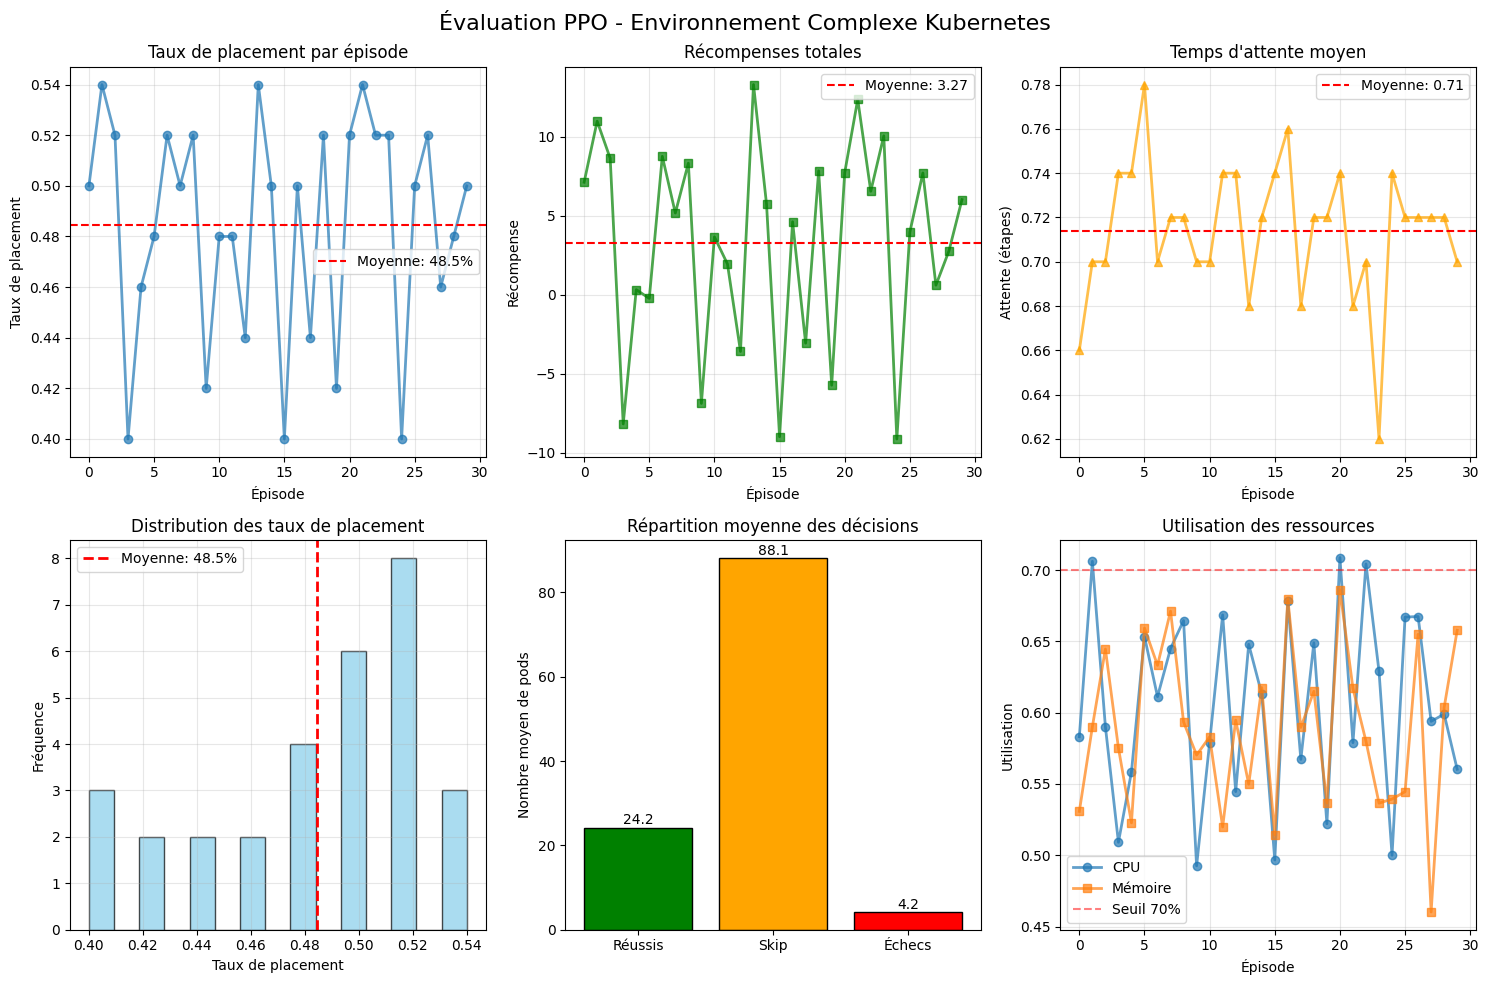


🎬 Test sur un épisode avec rendu détaillé...
  Step 10: Action=10, Reward=-0.20, Placement=skipped
  Step 20: Action=10, Reward=-0.20, Placement=skipped
  Step 30: Action=10, Reward=-0.20, Placement=skipped
  Step 40: Action=10, Reward=-0.20, Placement=skipped
  Step 50: Action=10, Reward=-0.20, Placement=skipped
  Step 60: Action=10, Reward=-0.30, Placement=skipped
  Step 70: Action=10, Reward=-0.30, Placement=skipped
  Step 80: Action=10, Reward=-0.30, Placement=skipped
  Step 90: Action=10, Reward=-0.80, Placement=abandoned
  Step 100: Action=1, Reward=1.57, Placement=success
  Step 110: Action=5, Reward=-1.00, Placement=abandoned

✅ Épisode terminé:
   • Steps: 113
   • Récompense totale: 2.98
   • Taux de placement: 48.0%

=== Épisode (Version Réaliste) ===
Étapes: 113
Pods placés: 24/50
Pods en attente: 0
Pods skipés: 81
Pods abandonnés: 8
Récompense totale: 2.02
Taux de placement final: 48.0%
Node 0: CPU 6.1/8.0 (75.8%), MEM 17.8/32.0 (55.7%)
Node 1: CPU 7.4/8.0 (92.1%), MEM 27

In [10]:
# Évaluation complète
print("\n📊 Démarrage de l'évaluation...")
metrics = ppo_agent_complex.evaluate_comprehensive(
    num_episodes=30,  # Plus d'épisodes pour une meilleure statistique
    render_every=5
)

# Visualisation
ppo_agent_complex.plot_evaluation_results(
    metrics,
    save_path="results/plots/ppo_complex_evaluation.png"
)

# Test sur un épisode avec rendu détaillé
print("\n🎬 Test sur un épisode avec rendu détaillé...")
obs, _ = env_complex.reset()
done = False
total_reward = 0
step = 0

while not done:
    action = ppo_agent_complex.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env_complex.step(action)
    
    total_reward += reward
    step += 1
    
    # Afficher des détails périodiquement
    if step % 10 == 0:
        print(f"  Step {step}: Action={action}, Reward={reward:.2f}, "
              f"Placement={info.get('placement', 'N/A')}")
    
    done = terminated or truncated
    
    # Limite de sécurité
    if step > 200:
        print("  ⚠️ Limite d'étapes atteinte")
        break

print(f"\n✅ Épisode terminé:")
print(f"   • Steps: {step}")
print(f"   • Récompense totale: {total_reward:.2f}")
print(f"   • Taux de placement: {env_complex.get_metrics()['placement_rate']:.1%}")

# Rendu final
env_complex.render()

# COMPARAISON AVEC LES AUTRES SCHEDULERS

In [15]:
import random
import numpy as np

class RandomSchedulerUniversal:
    def __init__(self, env):
        self.env = env
        self.num_nodes = env.num_nodes

    def schedule(self, pod):
        # Gestion des deux formats de pods
        if isinstance(pod, dict):
            cpu_req = pod.get('cpu_req', pod.get('cpu', 0))
            mem_req = pod.get('mem_req', pod.get('mem', 0))
        else:
            cpu_req, mem_req = pod[0], pod[1]
            
        # Chercher les nœuds disponibles
        feasible_nodes = []
        for i, node in enumerate(self.env.nodes):
            cpu_used, mem_used, cpu_total, mem_total = node
            if cpu_used + cpu_req <= cpu_total and mem_used + mem_req <= mem_total:
                feasible_nodes.append(i)
        
        if not feasible_nodes:
            return None
        
        return random.choice(feasible_nodes)

class ClassicSchedulerUniversal:
    def __init__(self, env):
        self.env = env
        self.num_nodes = env.num_nodes

    def schedule(self, pod):
        # Gestion des deux formats
        if isinstance(pod, dict):
            cpu_req = pod.get('cpu_req', pod.get('cpu', 0))
            mem_req = pod.get('mem_req', pod.get('mem', 0))
        else:
            cpu_req, mem_req = pod[0], pod[1]
            
        feasible_nodes = []
        for i, node in enumerate(self.env.nodes):
            cpu_used, mem_used, cpu_total, mem_total = node
            if cpu_used + cpu_req <= cpu_total and mem_used + mem_req <= mem_total:
                feasible_nodes.append((i, node))
        
        if not feasible_nodes:
            return None
        
        # Scoring simple : équilibre CPU/MEM
        best_node_idx, best_node = max(
            feasible_nodes,
            key=lambda x: 1.0 - abs((x[1][0] + cpu_req)/x[1][2] - (x[1][1] + mem_req)/x[1][3])
        )
        return best_node_idx
        

In [16]:
random_universal = RandomSchedulerUniversal(env_complex)    # <-- VOICI L'INSTANCE
classic_universal = ClassicSchedulerUniversal(env_complex)  

🔄 Démarrage de la comparaison des schedulers...

ÉVALUATION : PPO Agent
  Placement moyen: 46.8% ± 3.8%
  Récompense moyenne: 0.73 ± 6.06

ÉVALUATION : Random Scheduler
  Placement moyen: 60.7% ± 3.0%
  Récompense moyenne: 27.82 ± 4.73

ÉVALUATION : Classic Scheduler
  Placement moyen: 60.8% ± 3.7%
  Récompense moyenne: 28.79 ± 5.70

COMPARAISON FINALE DES SCHEDULERS

🎯 TAUX DE PLACEMENT:
  PPO Agent            : 46.8% ± 3.8%
  Random Scheduler     : 60.7% ± 3.0%
  Classic Scheduler    : 60.8% ± 3.7%

💰 RÉCOMPENSES TOTALES:
  PPO Agent            : 0.73 ± 6.06
  Random Scheduler     : 27.82 ± 4.73
  Classic Scheduler    : 28.79 ± 5.70


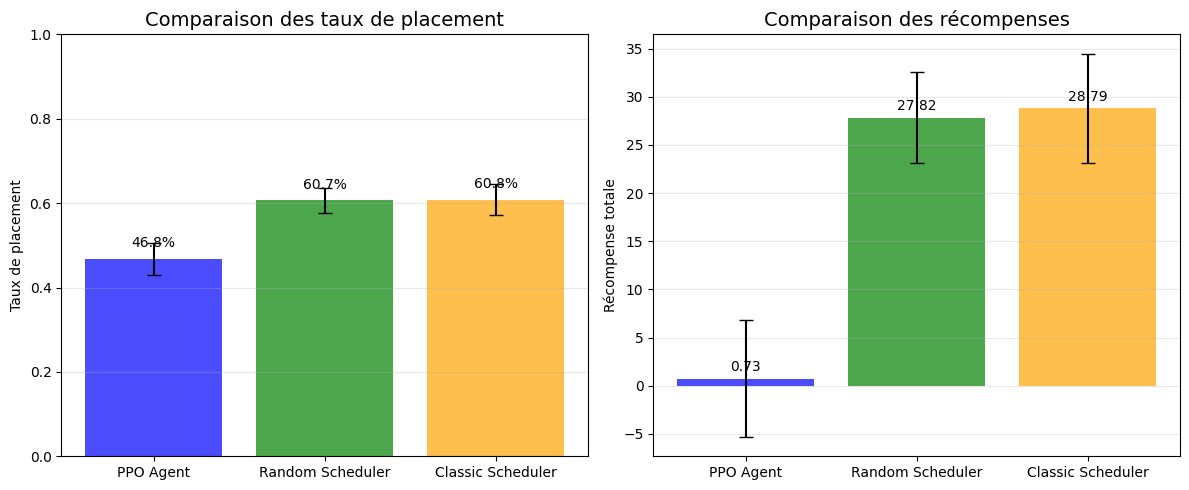

In [17]:
def compare_all_schedulers_complex(env, ppo_agent, random_scheduler, classic_scheduler, 
                                  num_episodes=20):
    """
    Compare les performances des différents schedulers sur l'environnement complexe
    """
    schedulers = [
        ("PPO Agent", ppo_agent),
        ("Random Scheduler", random_scheduler),
        ("Classic Scheduler", classic_scheduler)
    ]
    
    results = {}
    
    for name, scheduler in schedulers:
        print(f"\n{'='*50}")
        print(f"ÉVALUATION : {name}")
        print(f"{'='*50}")
        
        placement_rates = []
        total_rewards = []
        
        for episode in range(num_episodes):
            obs, _ = env.reset()
            done = False
            episode_reward = 0
            
            while not done:
                if isinstance(scheduler, PPOAgentComplex):
                    # Agent PPO
                    action = scheduler.predict(obs, deterministic=True)
                    obs, reward, terminated, truncated, info = env.step(action)
                else:
                    # Scheduler classique
                    if env.current_pod is None:
                        break
                    current_pod = env.current_pod
                    pod_for_scheduler = [current_pod['cpu_req'], current_pod['mem_req']]
                    action_idx = scheduler.schedule(pod_for_scheduler)
                    if action_idx is None:
                        action_idx = env.num_nodes
                    obs, reward, terminated, truncated, info = env.step(action_idx)
                
                episode_reward += reward
                done = terminated or truncated
            
            # Calcul des métriques
            final_metrics = env.get_metrics()
            placement_rates.append(final_metrics['placement_rate'])
            total_rewards.append(episode_reward)
        
        # Stocker les résultats
        results[name] = {
            'placement_mean': np.mean(placement_rates),
            'placement_std': np.std(placement_rates),
            'reward_mean': np.mean(total_rewards),
            'reward_std': np.std(total_rewards)
        }
        
        print(f"  Placement moyen: {np.mean(placement_rates):.1%} ± {np.std(placement_rates):.1%}")
        print(f"  Récompense moyenne: {np.mean(total_rewards):.2f} ± {np.std(total_rewards):.2f}")
    
    # Affichage comparatif
    print(f"\n{'='*60}")
    print("COMPARAISON FINALE DES SCHEDULERS")
    print(f"{'='*60}")
    
    print("\n🎯 TAUX DE PLACEMENT:")
    for name, data in results.items():
        print(f"  {name:20} : {data['placement_mean']:.1%} ± {data['placement_std']:.1%}")
    
    print("\n💰 RÉCOMPENSES TOTALES:")
    for name, data in results.items():
        print(f"  {name:20} : {data['reward_mean']:.2f} ± {data['reward_std']:.2f}")
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Graphique des placements
    names = list(results.keys())
    placement_means = [results[name]['placement_mean'] for name in names]
    placement_stds = [results[name]['placement_std'] for name in names]
    
    bars1 = ax1.bar(names, placement_means, yerr=placement_stds, 
                   capsize=5, alpha=0.7, color=['blue', 'green', 'orange'])
    ax1.set_title('Comparaison des taux de placement', fontsize=14)
    ax1.set_ylabel('Taux de placement')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars1, placement_means):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.1%}', ha='center', va='bottom')
    
    # Graphique des récompenses
    reward_means = [results[name]['reward_mean'] for name in names]
    reward_stds = [results[name]['reward_std'] for name in names]
    
    bars2 = ax2.bar(names, reward_means, yerr=reward_stds, 
                   capsize=5, alpha=0.7, color=['blue', 'green', 'orange'])
    ax2.set_title('Comparaison des récompenses', fontsize=14)
    ax2.set_ylabel('Récompense totale')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars2, reward_means):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{val:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig("results/plots/comparison_complex.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return results

# Exécuter la comparaison
print("🔄 Démarrage de la comparaison des schedulers...")
comparison_results = compare_all_schedulers_complex(
    env=env_complex,
    ppo_agent=ppo_agent_complex,
    random_scheduler=random_universal,  # Scheduler random universel
    classic_scheduler=classic_universal,  # Scheduler classic universel
    num_episodes=20
)